In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp, odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# set the path to the project directory
# os.chdir('/Users/olarinoyem/Project/data_driven_vaccination/')

os.chdir("/Users/ajaoo/Desktop/Projects/data_driven_vaccination/")

In [34]:
# Set up matplotlib

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        # Font settings for clarity and compatibility with academic publications
        "font.family": "serif",  # Consistent font family
        # "font.serif": ["Times", "Computer Modern Roman"],  # Preferred serif fonts
        "font.size": 14,  # Base font size for better readability
        "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
        # Figure aesthetics & size for detailed visuals and fit on publication pages
        "figure.figsize": (
            8,
            5,
        ),  # Adjusted figure size for a balance between detail and fit
        "figure.facecolor": "white",  # White figure background for clean print
        "figure.autolayout": True,  # Enable automatic layout adjustments
        "figure.dpi": 400,  # High resolution figures
        "savefig.dpi": 400,  # High resolution saving settings
        "savefig.format": "pdf",  # Save figures in PDF format for publications
        "savefig.bbox": "tight",  # Tight bounding box around figures
        # Axes aesthetics for clarity and precision
        "axes.labelsize": 14,  # Clear labeling with larger font size
        "axes.titlesize": 20,  # Prominent titles for immediate recognition
        "axes.facecolor": "white",  # White axes background
        # Legend aesthetics for distinguishing plot elements
        "legend.fontsize": 12,  # Readable legend font size
        "legend.frameon": False,  # No frame around legend for cleaner look
        "legend.loc": "best",  # Optimal legend positioning
        # Line aesthetics for clear visual distinctions
        "lines.linewidth": 2,  # Thicker lines for visibility
        "lines.markersize": 8,  # Slightly smaller markers for balance
        # Tick label sizes for readability
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.direction": "in",  # Ticks inside the plot
        "ytick.direction": "in",  # Ticks inside the plot
    }
)

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# load the data and check the first few rows
df = pd.read_csv("data/processed/england_data.csv").drop(columns=["Unnamed: 0"], axis=1)
df.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England


In [4]:
params = {
    "alpha": 0.1,  # Rate of transmission from the infected not requiring hospitalization
    "sigma": 0.1,  # Rate of transmission from the infected requiring hospitalization
    "beta": 0.17,  # Rate of transmission from the infected requiring hospitalization
    "gamma": 1 / 16,  # Recovery rate
    "theta": 0.001,  # Mortality rate
    "N": 56171302,  # Total population for England
    
    # Parameters for hospitalized and critical
    "rho": 0.05,  # Hospitalization rate for infected
    "delta": 0.01,  # Mortality rate for non-hospitalized
    "eta": 0.02,  # Rate at which hospitalized become critical
    "kappa": 0.03,  # Recovery rate for hospitalized
    "mu": 0.01,  # Recovery rate for critical
    "xi": 0.005,  # Mortality rate for critical
}

# Initial conditions [S0, I0, H0, C0, R0, D0] based on early data for England
initial_conditions = [56171302 - 20, 20, 0, 0, 0, 0]

In [5]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # # Apply rolling average
    # for col in ["cumulative_confirmed", "cumulative_deceased", "hospitalCases", "covidOccupiedMVBeds"]:
    #     df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """
    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        train_size (float): Proportion of the dataset to allocate to training.
        val_size (float): Proportion of the dataset to allocate to validation.
        test_size (float): Proportion of the dataset to allocate to testing.

    Returns:
        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)
    train_end = int(n * train_size)
    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

In [6]:
data = load_and_preprocess_data(
    "data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-01",
).drop("Unnamed: 0", axis=1)

data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England,0,0.0,30841.0,56135731.0
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England,1,0.0,34011.0,56131836.0
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England,2,0.0,37152.0,56127958.0
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England,3,0.0,39584.0,56124698.0
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England,4,0.0,41755.0,56121704.0


In [7]:
# select from the beginning of the pandemic in the data to the end of 2021
data = data[(data["date"] >= "2020-04-01") & (data["date"] <= "2020-12-31")]
data = data.reset_index(drop=True)
data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England,0,0.0,30841.0,56135731.0
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England,1,0.0,34011.0,56131836.0
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England,2,0.0,37152.0,56127958.0
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England,3,0.0,39584.0,56124698.0
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England,4,0.0,41755.0,56121704.0


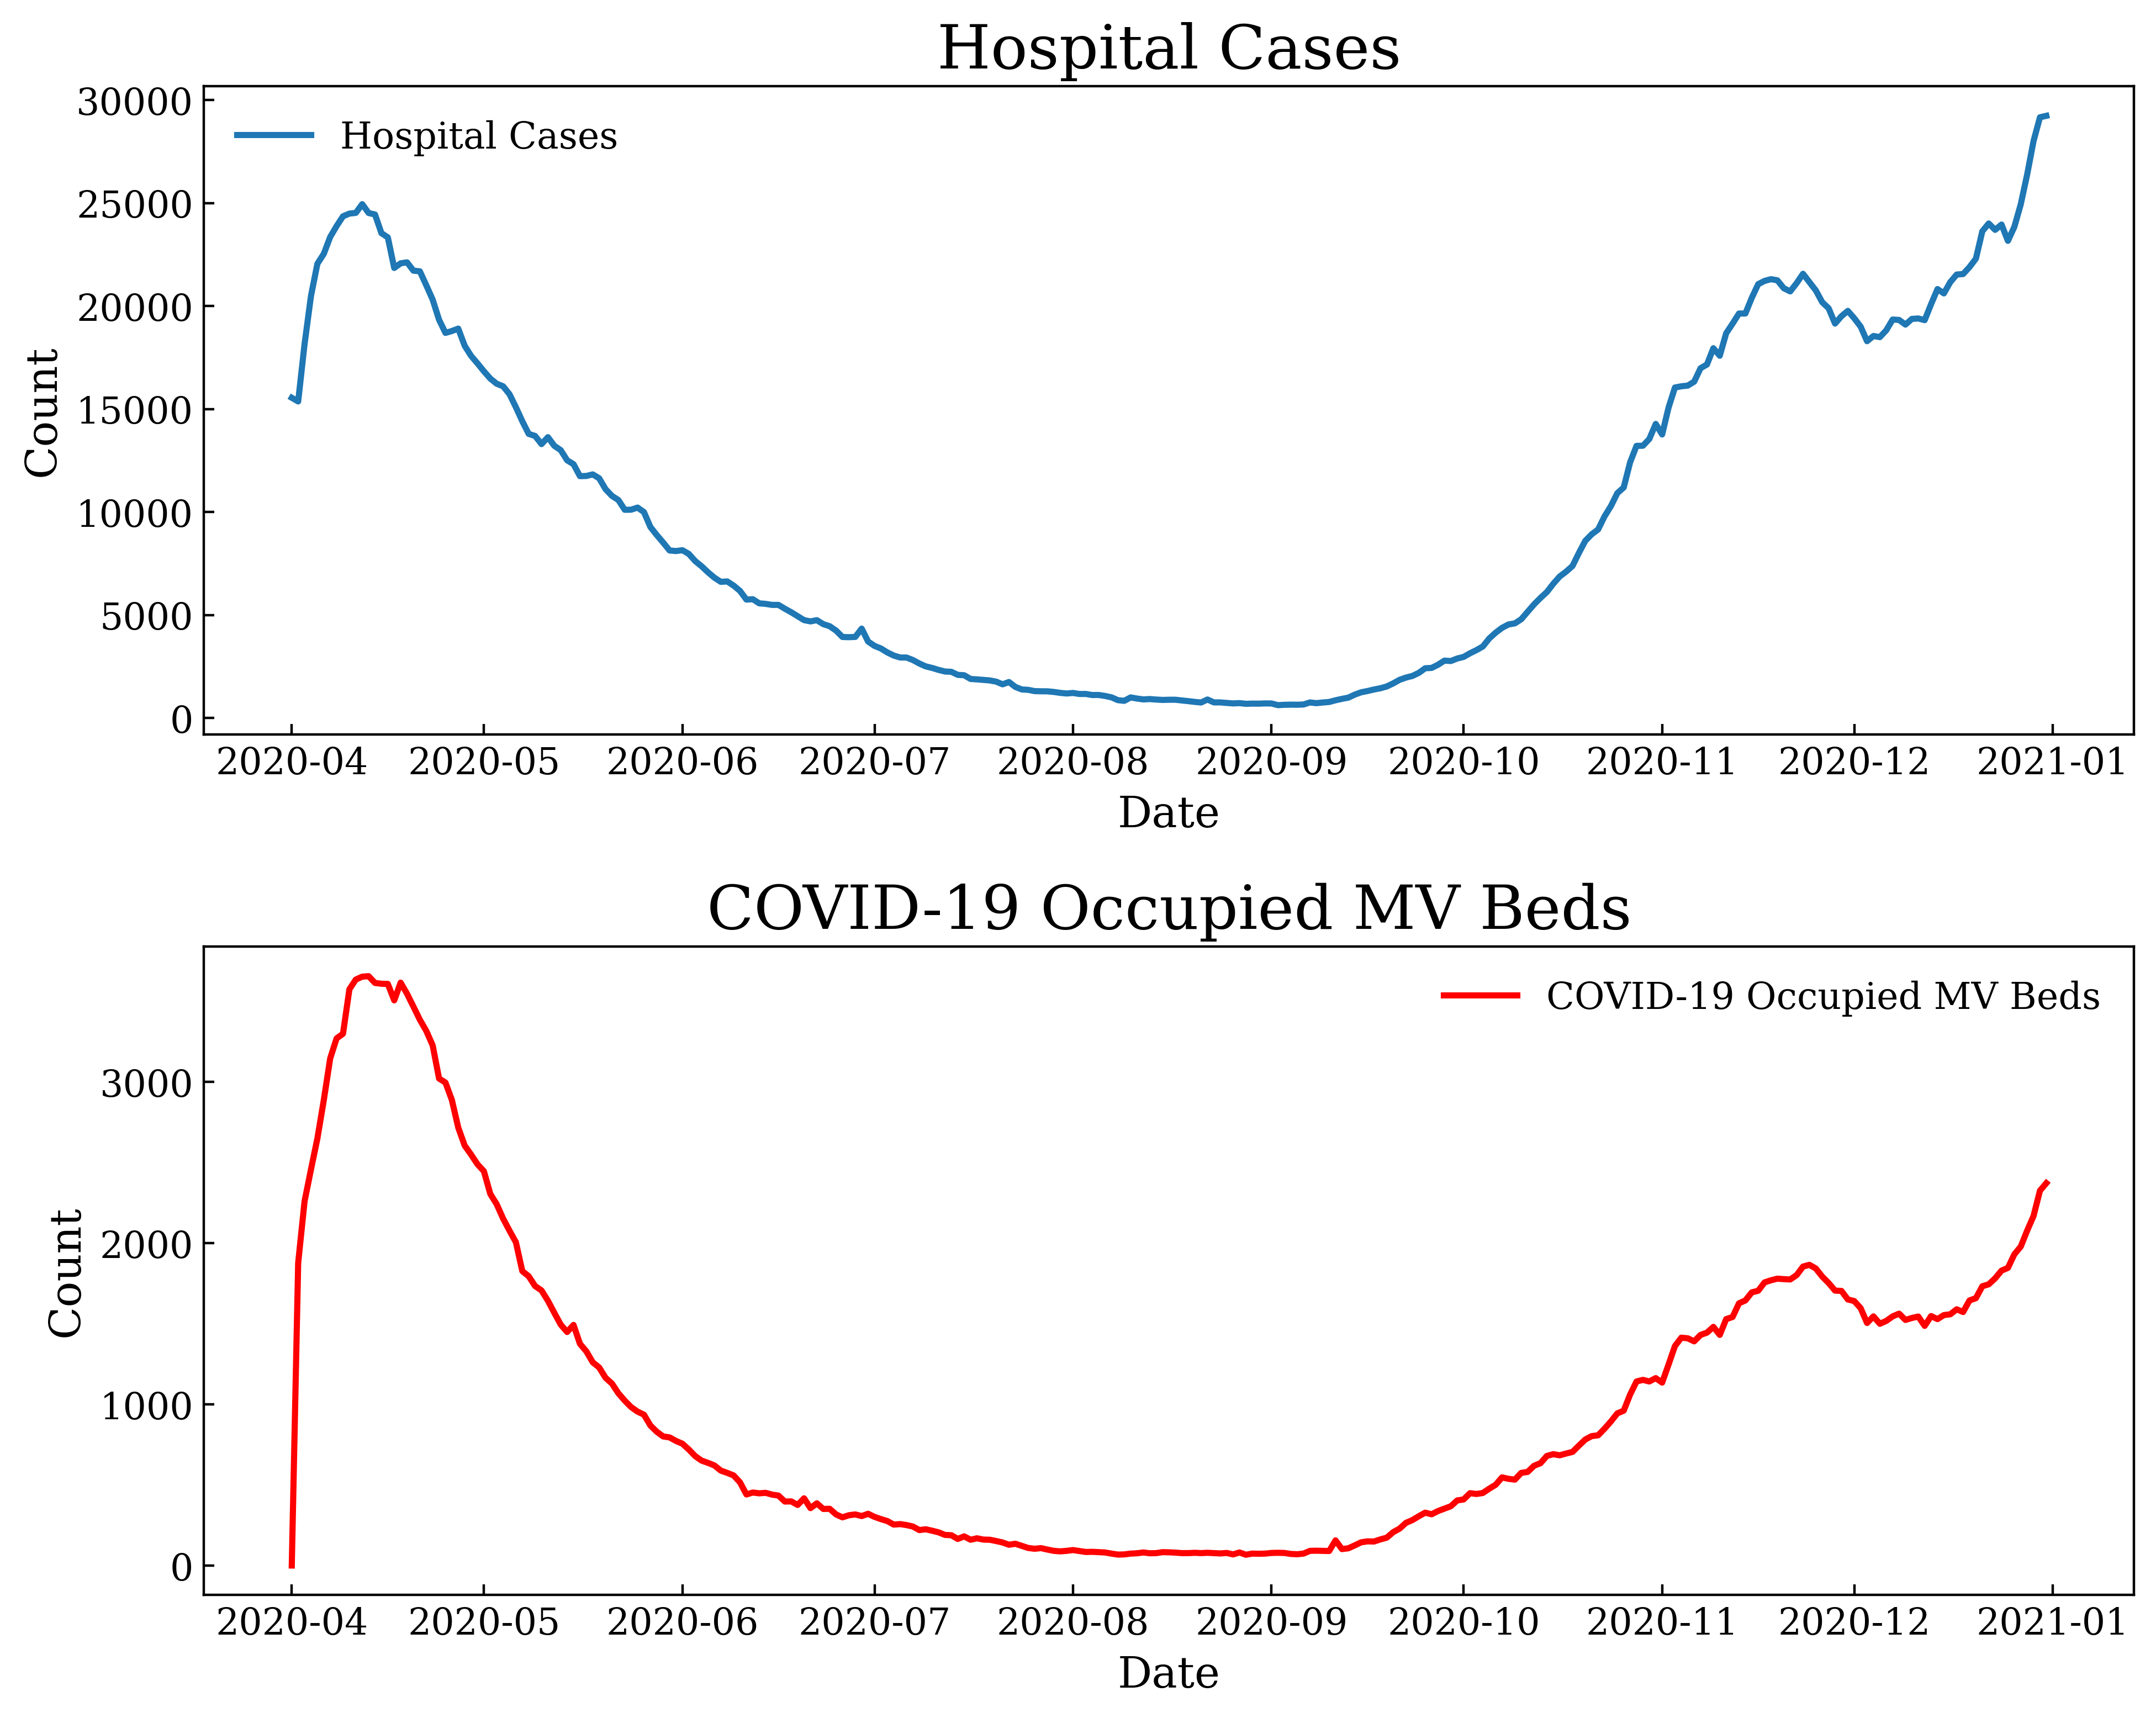

In [8]:
# visualize covidOccupiedMVBeds and hospitalCases on separate subplots
ax, fig = plt.subplots(2, 1, figsize=(10, 8))
fig[0].plot(data["date"], data["hospitalCases"], label="Hospital Cases")
fig[0].set_title("Hospital Cases")
fig[0].set_xlabel("Date")
fig[0].set_ylabel("Count")
fig[0].legend()

fig[1].plot(
    data["date"],
    data["covidOccupiedMVBeds"],
    label="COVID-19 Occupied MV Beds",
    color="red",
)
fig[1].set_title("COVID-19 Occupied MV Beds")
fig[1].set_xlabel("Date")
fig[1].set_ylabel("Count")
fig[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Split the data into training, validation, and test sets and scale the training data
train_data, val_data, test_data = split_time_series_data(
    data, train_size=0.7, val_size=0.15, test_size=0.15
)

scaler = MinMaxScaler()

# Scale and convert to DataFrame
features = [
    "cumulative_confirmed",
    "new_deceased",
    "covidOccupiedMVBeds",
    "hospitalCases",
    "recovered",
    "active_cases",
    "S(t)",
]
train_data_scaled = pd.DataFrame(
    scaler.fit_transform(train_data[features]), columns=features, index=train_data.index
)
val_data_scaled = pd.DataFrame(
    scaler.transform(val_data[features]), columns=features, index=val_data.index
)
test_data_scaled = pd.DataFrame(
    scaler.transform(test_data[features]), columns=features, index=test_data.index
)

In [10]:
def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = tensor(range(1, len(data) + 1), dtype=torch.float32).view(-1, 1).to(device).requires_grad_(True)
    S = tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = tensor(data["active_cases"].values, dtype=torch.float32).view(-1, 1).to(device)
    R = tensor(data["recovered"].values, dtype=torch.float32).view(-1, 1).to(device)
    D = tensor(data["new_deceased"].values, dtype=torch.float32).view(-1, 1).to(device)
    H = tensor(data["hospitalCases"].values, dtype=torch.float32).view(-1, 1).to(device)
    C = (
        tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, S, I, R, D, H, C



# Prepare tensors for each dataset

t_train, S_train, I_train, R_train, D_train, H_train, C_train = prepare_tensors(
    train_data_scaled, device
)
t_val, S_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(
    val_data_scaled, device
)
t_test, S_test, I_test, R_test, D_test, H_test, C_test = prepare_tensors(
    test_data_scaled, device
)

SIHCRD_tensor_train = torch.cat((S_train, I_train, H_train, C_train, R_train, D_train), dim=1)
SIHCRD_tensor_val = torch.cat((S_val, I_val, H_val, C_val, R_val, D_val), dim=1)
SIHCRD_tensor_test = torch.cat((S_test, I_test, H_test, C_test, R_test, D_test), dim=1)

In [11]:
def seihcrd_model(t, y, params):
    S, E, I, H, C, R, D = y
    N = params["N"]
    dSdt = -(params["beta"] * I / N) * S
    dEdt = (params["beta"] * I / N) * S - params["sigma"] * E
    dIdt = params["sigma"] * E - (params["gamma"] + params["rho"] + params["delta"]) * I
    dHdt = params["rho"] * I - (params["eta"] + params["kappa"]) * H
    dCdt = params["eta"] * H - (params["mu"] + params["xi"]) * C
    dRdt = params["gamma"] * I + params["kappa"] * H + params["mu"] * C
    dDdt = params["delta"] * I + params["xi"] * C
    return [dSdt, dEdt, dIdt, dHdt, dCdt, dRdt, dDdt]

def sihcrd_model(t, y, params):
    S, I, H, C, R, D = y
    N = params["N"]
    beta = params["beta"]
    gamma = 0.125
    rho = 0.03
    delta = 0.02
    eta = 0.125
    kappa = 0.01875
    mu = 0.14
    xi = 0.143

    S = N - sum(y)  # Recompute S based on other compartments
    dSdt = -(beta * I / N) * S
    dIdt = (beta * S / N) * I - (gamma + rho + delta) * I
    dHdt = rho * I - (eta + kappa) * H
    dCdt = eta * H - (mu + xi) * C
    dRdt = gamma * I + mu * C
    dDdt = delta * I + xi * C
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


In [12]:
# Define the neural network model with parameters estimation for the SIHCRD model
class SIHCRDNet(nn.Module):
    def __init__(
        self,
        init_beta=None,
        init_mu=None,
        init_delta=None,
        init_xi=None,
        retrain_seed=42,
        num_layers=4,
        hidden_neurons=20,
    ):
        super(SIHCRDNet, self).__init__()
        self.retrain_seed = retrain_seed
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()]
        layers.append(nn.Linear(hidden_neurons, 6))  # Output layer for S, I, H, C, R, D
        self.net = nn.Sequential(*layers)
        
        # # Fixed parameters
        # self.gamma = 0.125  # Recovery rate
        # self.rho = 0.03  # Hospitalization rate
        # self.eta = 0.125  # Transition to critical state
        # self.kappa = 0.01875  # Recovery rate
        
        # Time varying learnable parameters
        self.beta = nn.Parameter(torch.tensor([init_beta if init_beta is not None else torch.rand(1)], device=device), requires_grad=True)
        self.mu = nn.Parameter(torch.tensor([init_mu if init_mu is not None else torch.rand(1)], device=device), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([init_delta if init_delta is not None else torch.rand(1)], device=device), requires_grad=True)
        self.xi = nn.Parameter(torch.tensor([init_xi if init_xi is not None else torch.rand(1)], device=device), requires_grad=True)
        
        # Initialize the network weights
        self.init_xavier()
        
    def forward(self, t):
        return self.net(t)
    
    # parameter estimation range for beta 0.1 to 1.0
    @property
    def beta(self):
        return torch.sigmoid(self._beta) * 0.9 + 0.1 if self._beta is not None else None
    
    # parameter estimation range for mu 0.01 to 0.2
    @property
    def mu(self):
        return torch.sigmoid(self._mu) * 0.19 + 0.01 if self._mu is not None else None
    
    # parameter estimation range for delta 0.01 to 0.2
    @property
    def delta(self):
        return torch.sigmoid(self._delta) * 0.19 + 0.01 if self._delta is not None else None
    
    # parameter estimation range for xi 0.005 to 0.1
    @property
    def xi(self):
        return torch.sigmoid(self._xi) * 0.095 + 0.005 if self._xi is not None else None
        
    # Initialize the neural network with Xavier Initialization
    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)
        

In [13]:
# Define the loss function for the SIHCRD model
def sihcrd_loss(
    model,
    model_output,
    SIHCRD_tensor_train,
    t_train,
    N,
    beta=None,
    mu=None,
    delta=None,
    xi=None
):
    S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5]
    S_true, I_true, H_true, C_true, R_true, D_true = SIHCRD_tensor_train[:, 0], SIHCRD_tensor_train[:, 1], SIHCRD_tensor_train[:, 2], SIHCRD_tensor_train[:, 3], SIHCRD_tensor_train[:, 4], SIHCRD_tensor_train[:, 5]
    
    #derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_train, grad_outputs=torch.ones_like(S_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_train, grad_outputs=torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_train, grad_outputs=torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_train, grad_outputs=torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_train, grad_outputs=torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_train, grad_outputs=torch.ones_like(D_pred), create_graph=True)[0]
    
    # fixed parameters
    gamma = 0.125
    rho = 0.03
    eta = 0.125
    kappa = 0.01875
    
    # Time varying parameters 
    beta = model.beta
    mu = model.mu
    delta = model.delta
    xi = model.xi   
    
    # SIHCRD model equations
    dSdt = -(beta * I_true / N) * S_true
    dIdt = (beta * S_true / N) * I_true - (gamma + rho + delta) * I_true
    dHdt = rho * I_true - (eta + kappa) * H_true
    dCdt = eta * H_true - (mu + xi) * C_true
    dRdt = gamma * I_true + kappa * H_true + mu * C_true
    dDdt = delta * I_true + xi * C_true
    
    # physical informed loss
    loss = nn.MSELoss()(S_t, dSdt) + nn.MSELoss()(I_t, dIdt) + nn.MSELoss()(H_t, dHdt) + nn.MSELoss()(C_t, dCdt) + nn.MSELoss()(R_t, dRdt) + nn.MSELoss()(D_t, dDdt)
    
    # data fitting loss
    loss += nn.MSELoss()(S_pred, S_true) + nn.MSELoss()(I_pred, I_true) + nn.MSELoss()(H_pred, H_true) + nn.MSELoss()(C_pred, C_true) + nn.MSELoss()(R_pred, R_true) + nn.MSELoss()(D_pred, D_true) 
    
    return loss 


In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


In [26]:
def train_sihcrd_model(
    model,
    t_train,    
    SIHCRD_tensor_train,
    epoch=1000, 
    lr=1e-1,
    N=None,
    beta=None,
    mu=None,
    delta=None,
    xi=None,
    patience=5,
):
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adamax optimizer
    # scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)
        # Initialize the early stopping callback
    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    losses = []
    
    for i in tqdm(range(epoch)):
        model.train()
        optimizer.zero_grad()
        model_output = model(t_train)
        loss = sihcrd_loss(model, model_output, SIHCRD_tensor_train, t_train, N, beta, mu, delta, xi)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        
        if i % 500 == 0:
            print(f"Epoch {i} Loss: {loss.item():.4f}")
            
            
        # Early stopping
        # early_stopping(loss)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break               
        
        # Reduce learning rate on loss plateau 
        # scheduler.step(loss)        
        
    return losses 


In [27]:
model = SIHCRDNet(init_beta=0.1, init_mu=0.01, init_delta=0.01, init_xi=0.005, num_layers=6, hidden_neurons=32).to(device)  

losses = train_sihcrd_model(
    model,
    t_train,
    SIHCRD_tensor_train,
    epoch=20000,
    lr=1e-4,
    N=params["N"],
    patience=20,
)       

  0%|          | 0/20000 [00:00<?, ?it/s]c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 4/20000 [00:00<13:16, 25.12it/s]

Epoch 0 Loss: 5.0142


  3%|▎         | 510/20000 [00:11<07:11, 45.18it/s]

Epoch 500 Loss: 0.0683


  5%|▌         | 1007/20000 [00:23<06:56, 45.56it/s]

Epoch 1000 Loss: 0.0559


  8%|▊         | 1507/20000 [00:34<07:31, 40.93it/s]

Epoch 1500 Loss: 0.0513


 10%|█         | 2006/20000 [00:46<10:16, 29.18it/s]

Epoch 2000 Loss: 0.0432


 13%|█▎        | 2506/20000 [00:57<06:42, 43.48it/s]

Epoch 2500 Loss: 0.0284


 15%|█▌        | 3008/20000 [01:08<05:57, 47.48it/s]

Epoch 3000 Loss: 0.0195


 18%|█▊        | 3507/20000 [01:19<05:59, 45.91it/s]

Epoch 3500 Loss: 0.0142


 20%|██        | 4007/20000 [01:31<05:53, 45.19it/s]

Epoch 4000 Loss: 0.0117


 23%|██▎       | 4509/20000 [01:42<05:34, 46.26it/s]

Epoch 4500 Loss: 0.0101


 25%|██▌       | 5009/20000 [01:53<05:27, 45.76it/s]

Epoch 5000 Loss: 0.0091


 28%|██▊       | 5507/20000 [02:04<05:17, 45.65it/s]

Epoch 5500 Loss: 0.0082


 30%|███       | 6010/20000 [02:15<05:03, 46.14it/s]

Epoch 6000 Loss: 0.0077


 33%|███▎      | 6505/20000 [02:26<04:50, 46.44it/s]

Epoch 6500 Loss: 0.0073


 35%|███▌      | 7008/20000 [02:37<04:44, 45.68it/s]

Epoch 7000 Loss: 0.0070


 38%|███▊      | 7508/20000 [02:49<04:44, 43.98it/s]

Epoch 7500 Loss: 0.0068


 40%|████      | 8007/20000 [03:00<04:24, 45.31it/s]

Epoch 8000 Loss: 0.0067


 43%|████▎     | 8509/20000 [03:12<04:10, 45.82it/s]

Epoch 8500 Loss: 0.0066


 45%|████▌     | 9007/20000 [03:23<04:01, 45.56it/s]

Epoch 9000 Loss: 0.0065


 48%|████▊     | 9507/20000 [03:34<03:44, 46.73it/s]

Epoch 9500 Loss: 0.0065


 50%|█████     | 10008/20000 [03:45<03:46, 44.11it/s]

Epoch 10000 Loss: 0.0064


 53%|█████▎    | 10506/20000 [03:56<03:25, 46.09it/s]

Epoch 10500 Loss: 0.0064


 55%|█████▌    | 11010/20000 [04:07<03:09, 47.33it/s]

Epoch 11000 Loss: 0.0064


 58%|█████▊    | 11507/20000 [04:18<03:09, 44.81it/s]

Epoch 11500 Loss: 0.0069


 60%|██████    | 12008/20000 [04:29<03:03, 43.64it/s]

Epoch 12000 Loss: 0.0064


 63%|██████▎   | 12507/20000 [04:40<02:38, 47.33it/s]

Epoch 12500 Loss: 0.0064


 65%|██████▌   | 13006/20000 [04:51<02:34, 45.14it/s]

Epoch 13000 Loss: 0.0064


 68%|██████▊   | 13507/20000 [05:02<02:24, 44.98it/s]

Epoch 13500 Loss: 0.0064


 70%|███████   | 14010/20000 [05:13<02:10, 45.77it/s]

Epoch 14000 Loss: 0.0064


 73%|███████▎  | 14507/20000 [05:24<01:58, 46.43it/s]

Epoch 14500 Loss: 0.0064


 75%|███████▌  | 15005/20000 [05:35<01:46, 47.05it/s]

Epoch 15000 Loss: 0.0064


 78%|███████▊  | 15507/20000 [05:47<01:37, 45.99it/s]

Epoch 15500 Loss: 0.0064


 80%|████████  | 16006/20000 [05:57<01:27, 45.42it/s]

Epoch 16000 Loss: 0.0064


 83%|████████▎ | 16509/20000 [06:09<01:21, 42.63it/s]

Epoch 16500 Loss: 0.0063


 85%|████████▌ | 17006/20000 [06:19<01:02, 48.12it/s]

Epoch 17000 Loss: 0.0063


 88%|████████▊ | 17506/20000 [06:31<00:58, 42.82it/s]

Epoch 17500 Loss: 0.0063


 90%|█████████ | 18008/20000 [06:42<00:45, 44.09it/s]

Epoch 18000 Loss: 0.0063


 93%|█████████▎| 18505/20000 [06:53<00:33, 44.53it/s]

Epoch 18500 Loss: 0.0063


 95%|█████████▌| 19006/20000 [07:04<00:22, 44.63it/s]

Epoch 19000 Loss: 0.0065


 98%|█████████▊| 19509/20000 [07:15<00:10, 45.35it/s]

Epoch 19500 Loss: 0.0063


100%|██████████| 20000/20000 [07:26<00:00, 44.79it/s]


ValueError: zero-size array to reduction operation minimum which has no identity

c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


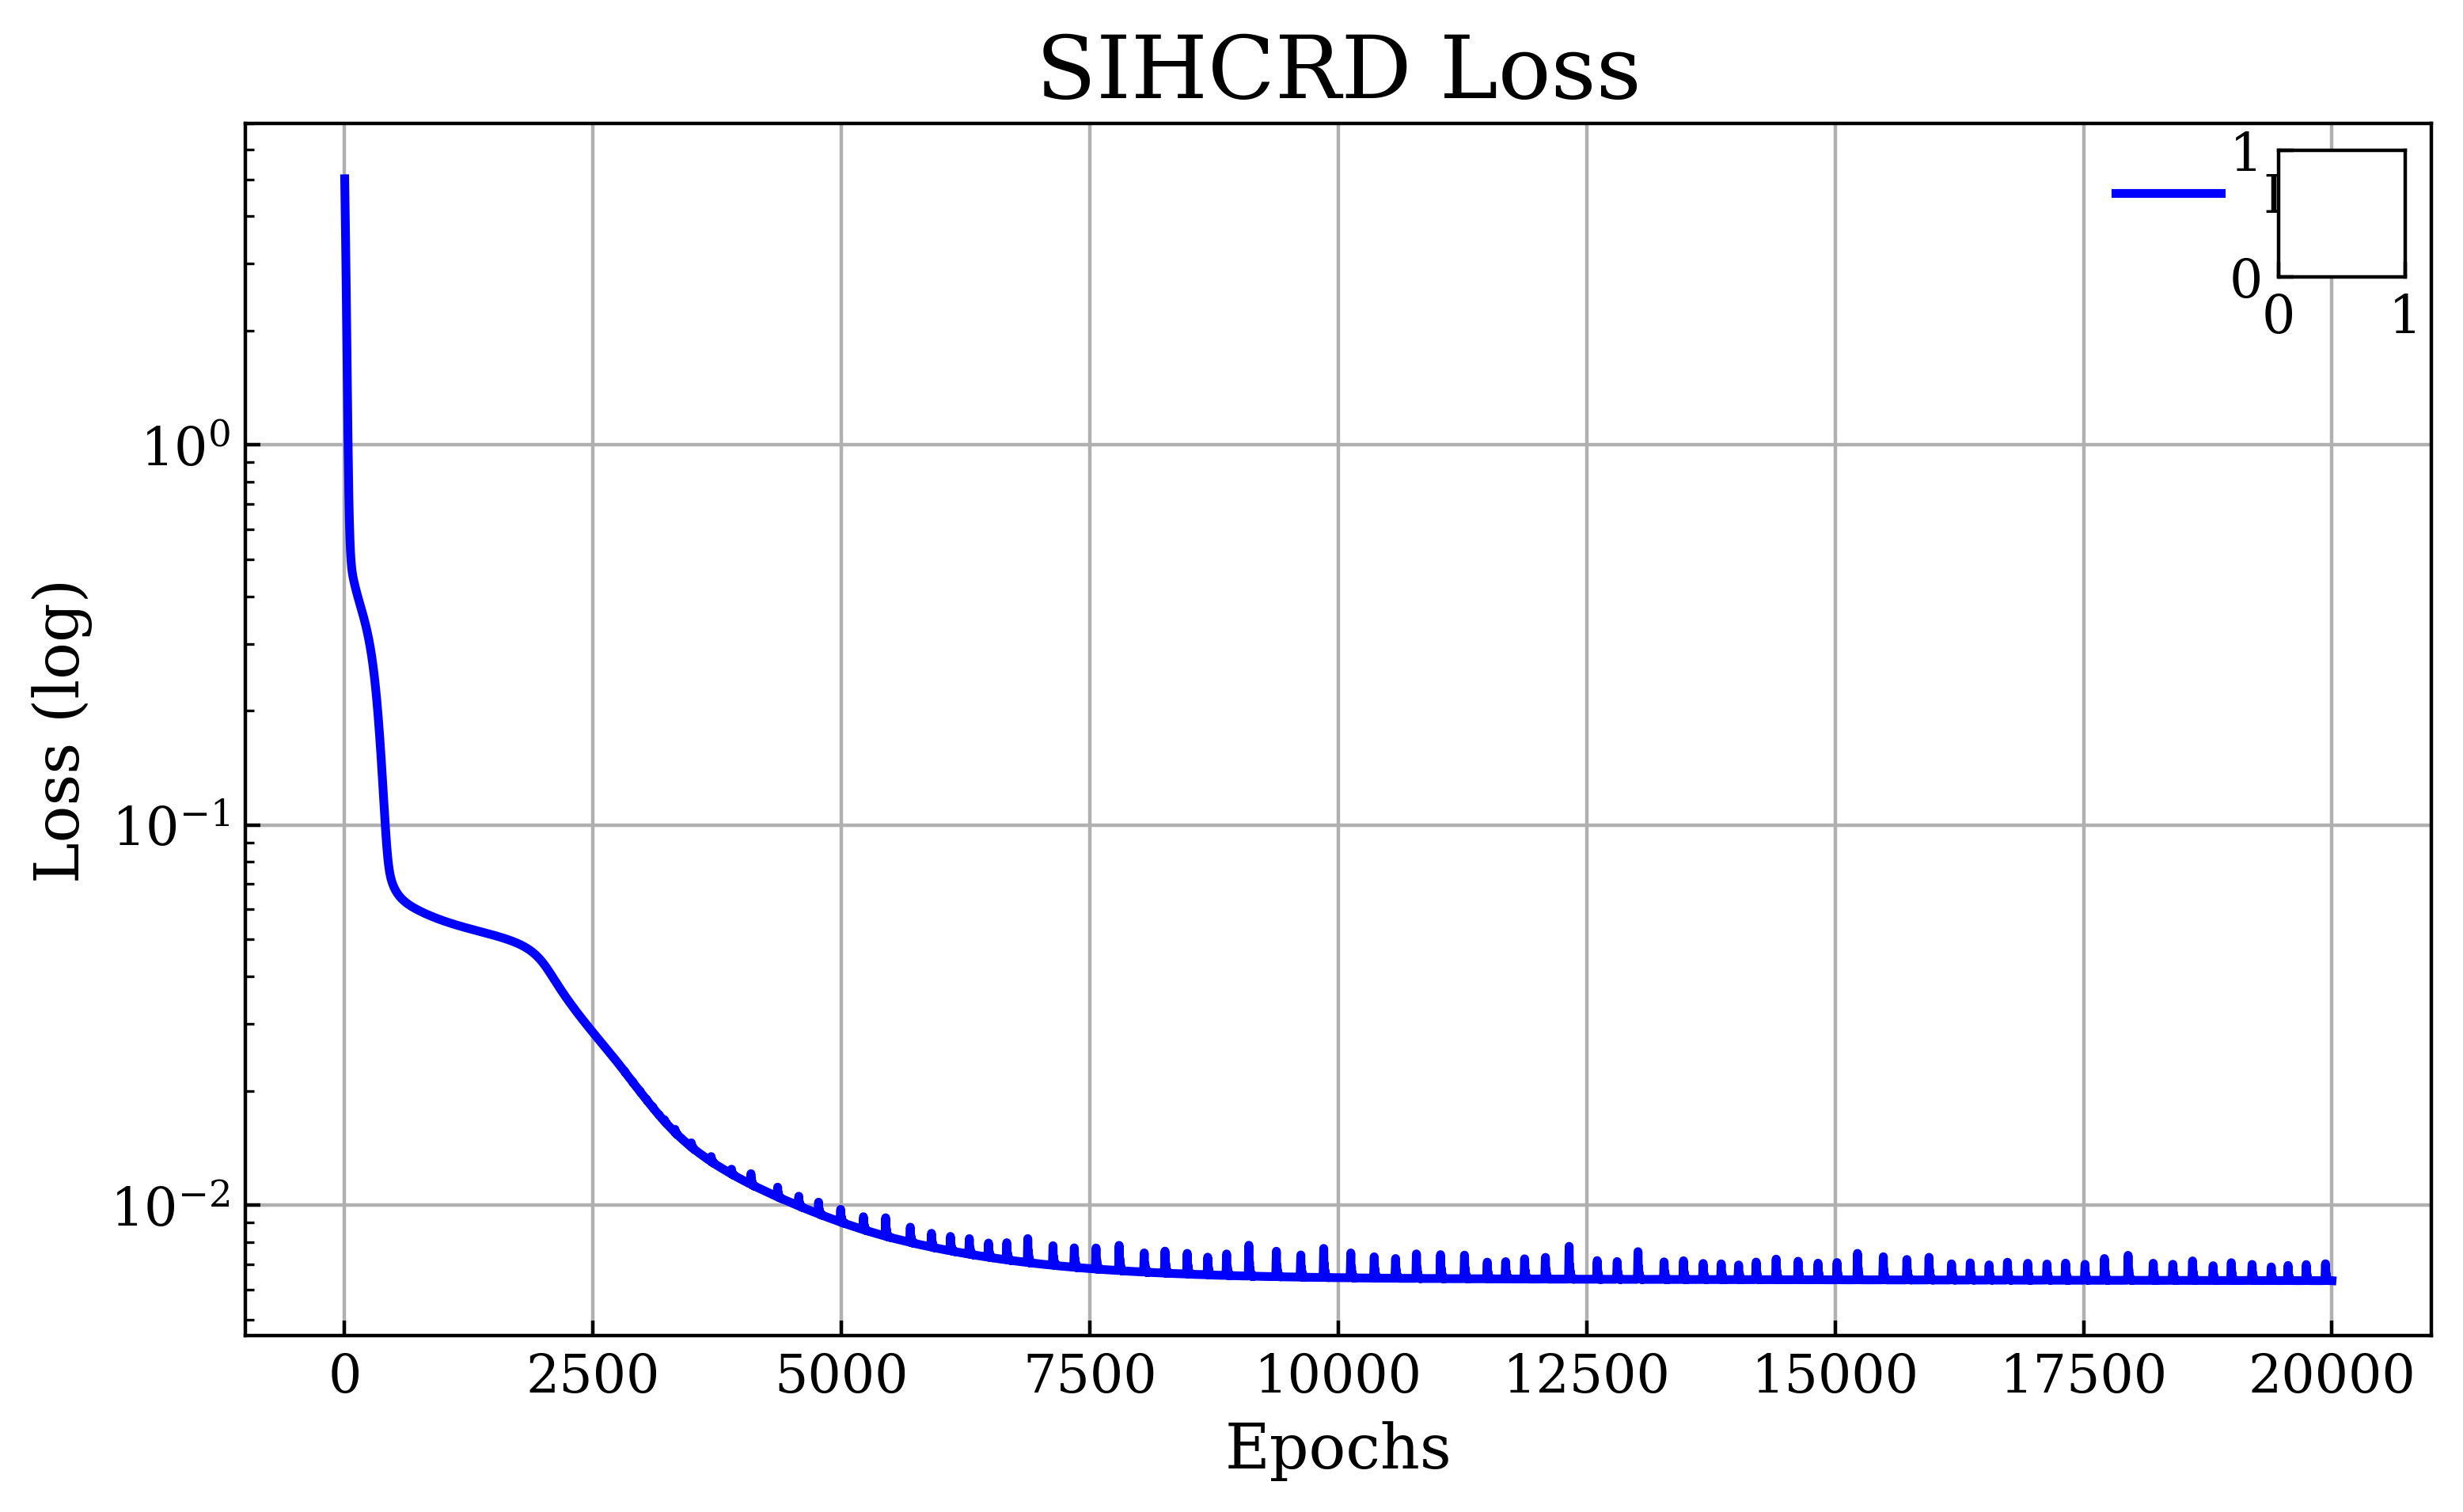

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_loss(
    losses,
    title,
    save_path="reports/figures",
    show=True,
    figsize=(8, 5),
    grid=True,
    save_format="pdf",
    inset_bounds=(0.5, 0.5, 0.4, 0.4),  # Inset bounds as (x, y, width, height)
    inset_zoom_bounds=(45000, 50000)    # Zoom bounds for the inset plot (x-axis)
):
    """
    Enhanced plotting function for the training loss of a model with an inset zoom plot.

    Args:
    - losses (list or array): A list or array of loss values per epoch.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (8, 5).
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.
    - inset_bounds (tuple, optional): Bounds for the inset plot as a fraction of the figure size.
    - inset_zoom_bounds (tuple, optional): Tuple of (start, end) defining the range for the zoom in the inset plot.

    Returns:
    None
    """
    
    fig, ax_main = plt.subplots(figsize=figsize)
    
    # Main plot with log scale
    ax_main.plot(np.arange(1, len(losses) + 1), losses, label="Loss", color="blue")
    ax_main.set_yscale('log')  # Logarithmic scale for the y-axis
    ax_main.set_title(f"{title} Loss")
    ax_main.set_xlabel("Epochs")
    ax_main.set_ylabel("Loss (log)")
    ax_main.legend()
    ax_main.grid(grid)
    
    # Inset plot with linear scale
    ax_inset = inset_axes(ax_main, width=inset_bounds[2], height=inset_bounds[3], loc=1)
    x1, x2 = inset_zoom_bounds
    y1, y2 = np.min(losses[x1:x2]), np.max(losses[x1:x2])
    ax_inset.plot(np.arange(1, len(losses) + 1), losses, color="blue")
    ax_inset.set_xlim(x1, x2)
    ax_inset.set_ylim(y1, y2)
    ax_inset.set_title('Zoom')
    ax_inset.grid(True)
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(f"{save_path}/{title.replace(' ', '_')}_Loss.{save_format}")
    
    # Show the plot if requested
    if show:
        plt.show()
        

plot_loss(losses, title="SIHCRD")

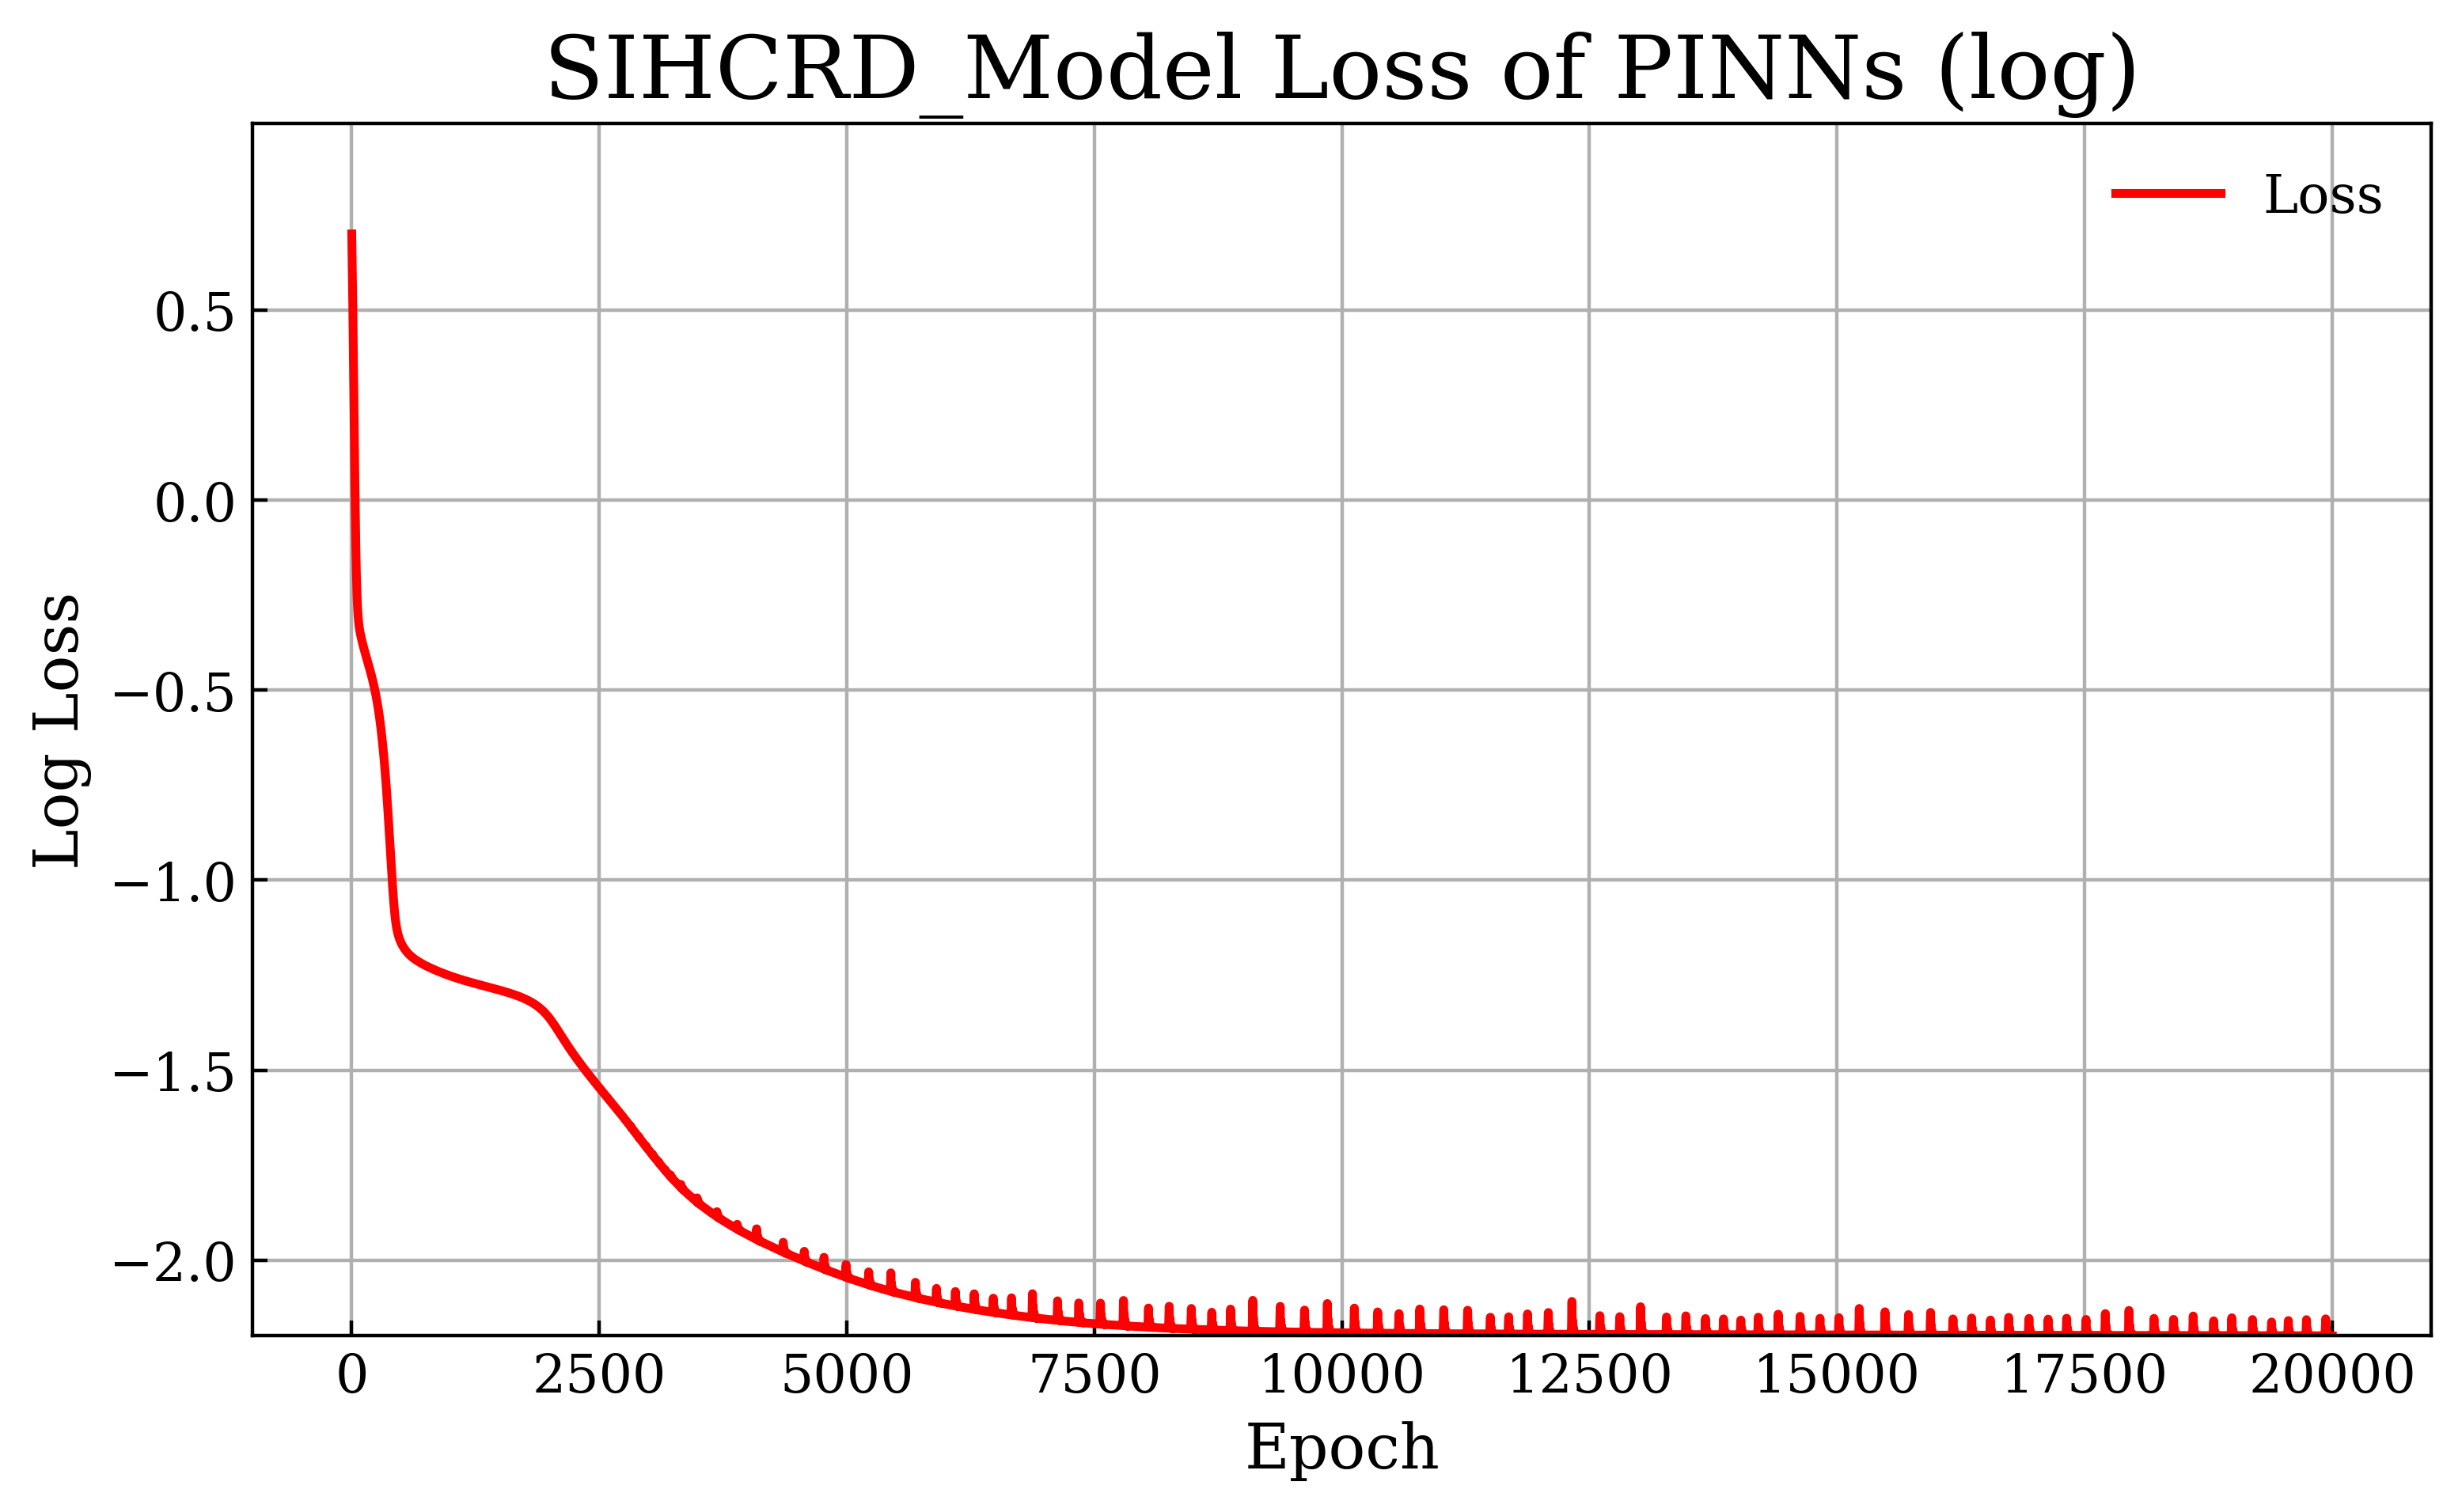

In [32]:
def plot_loss(
    losses,
    title,
    save_path="reports/figures",
    show=True,
    figsize=(8, 5),
    grid=True,
    save_format="pdf",
):
    """
    Enhanced plotting function for the training loss of a model, with logarithmic y-axis.

    Args:
    - losses (list or dict): A list of loss values per epoch, or a dictionary of lists for multiple loss components.
    - title (str): Title for the plot.
    - save_path (str, optional): Directory to save the plot. Default is "reports/figures".
    - show (bool, optional): Whether to display the plot. Default is True.
    - figsize (tuple, optional): Figure size. Default is (8, 5).
    - grid (bool, optional): Whether to show grid lines. Default is True.
    - save_format (str, optional): Format to save the plot (e.g., 'pdf', 'png'). Default is 'pdf'.

    Returns:
    None
    """
    
    # Logarithmic y-axis
    log_losses = [np.log10(loss) for loss in losses]
    min_loss = min(log_losses)
    max_loss = max(log_losses)

    plt.figure(figsize=figsize)
    plt.plot(np.arange(1, len(losses) + 1), log_losses, label="Loss", color="Red")
    plt.title(f"{title} Loss of PINNs (log)")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.ylim(min_loss, max(log_losses) + 0.1 * (max(log_losses) - min_loss))  # Setting the y-axis limit
    plt.grid(grid)
    plt.legend()

    if save_path:
        plt.savefig(f"{save_path}/{title.replace(' ', '_')}_Loss_of_PINNs_log.{save_format}")
    if show:
        plt.show()
        
plot_loss(losses, "SIHCRD_Model")

In [29]:
# plot just I compartment and rescale it back to original scale


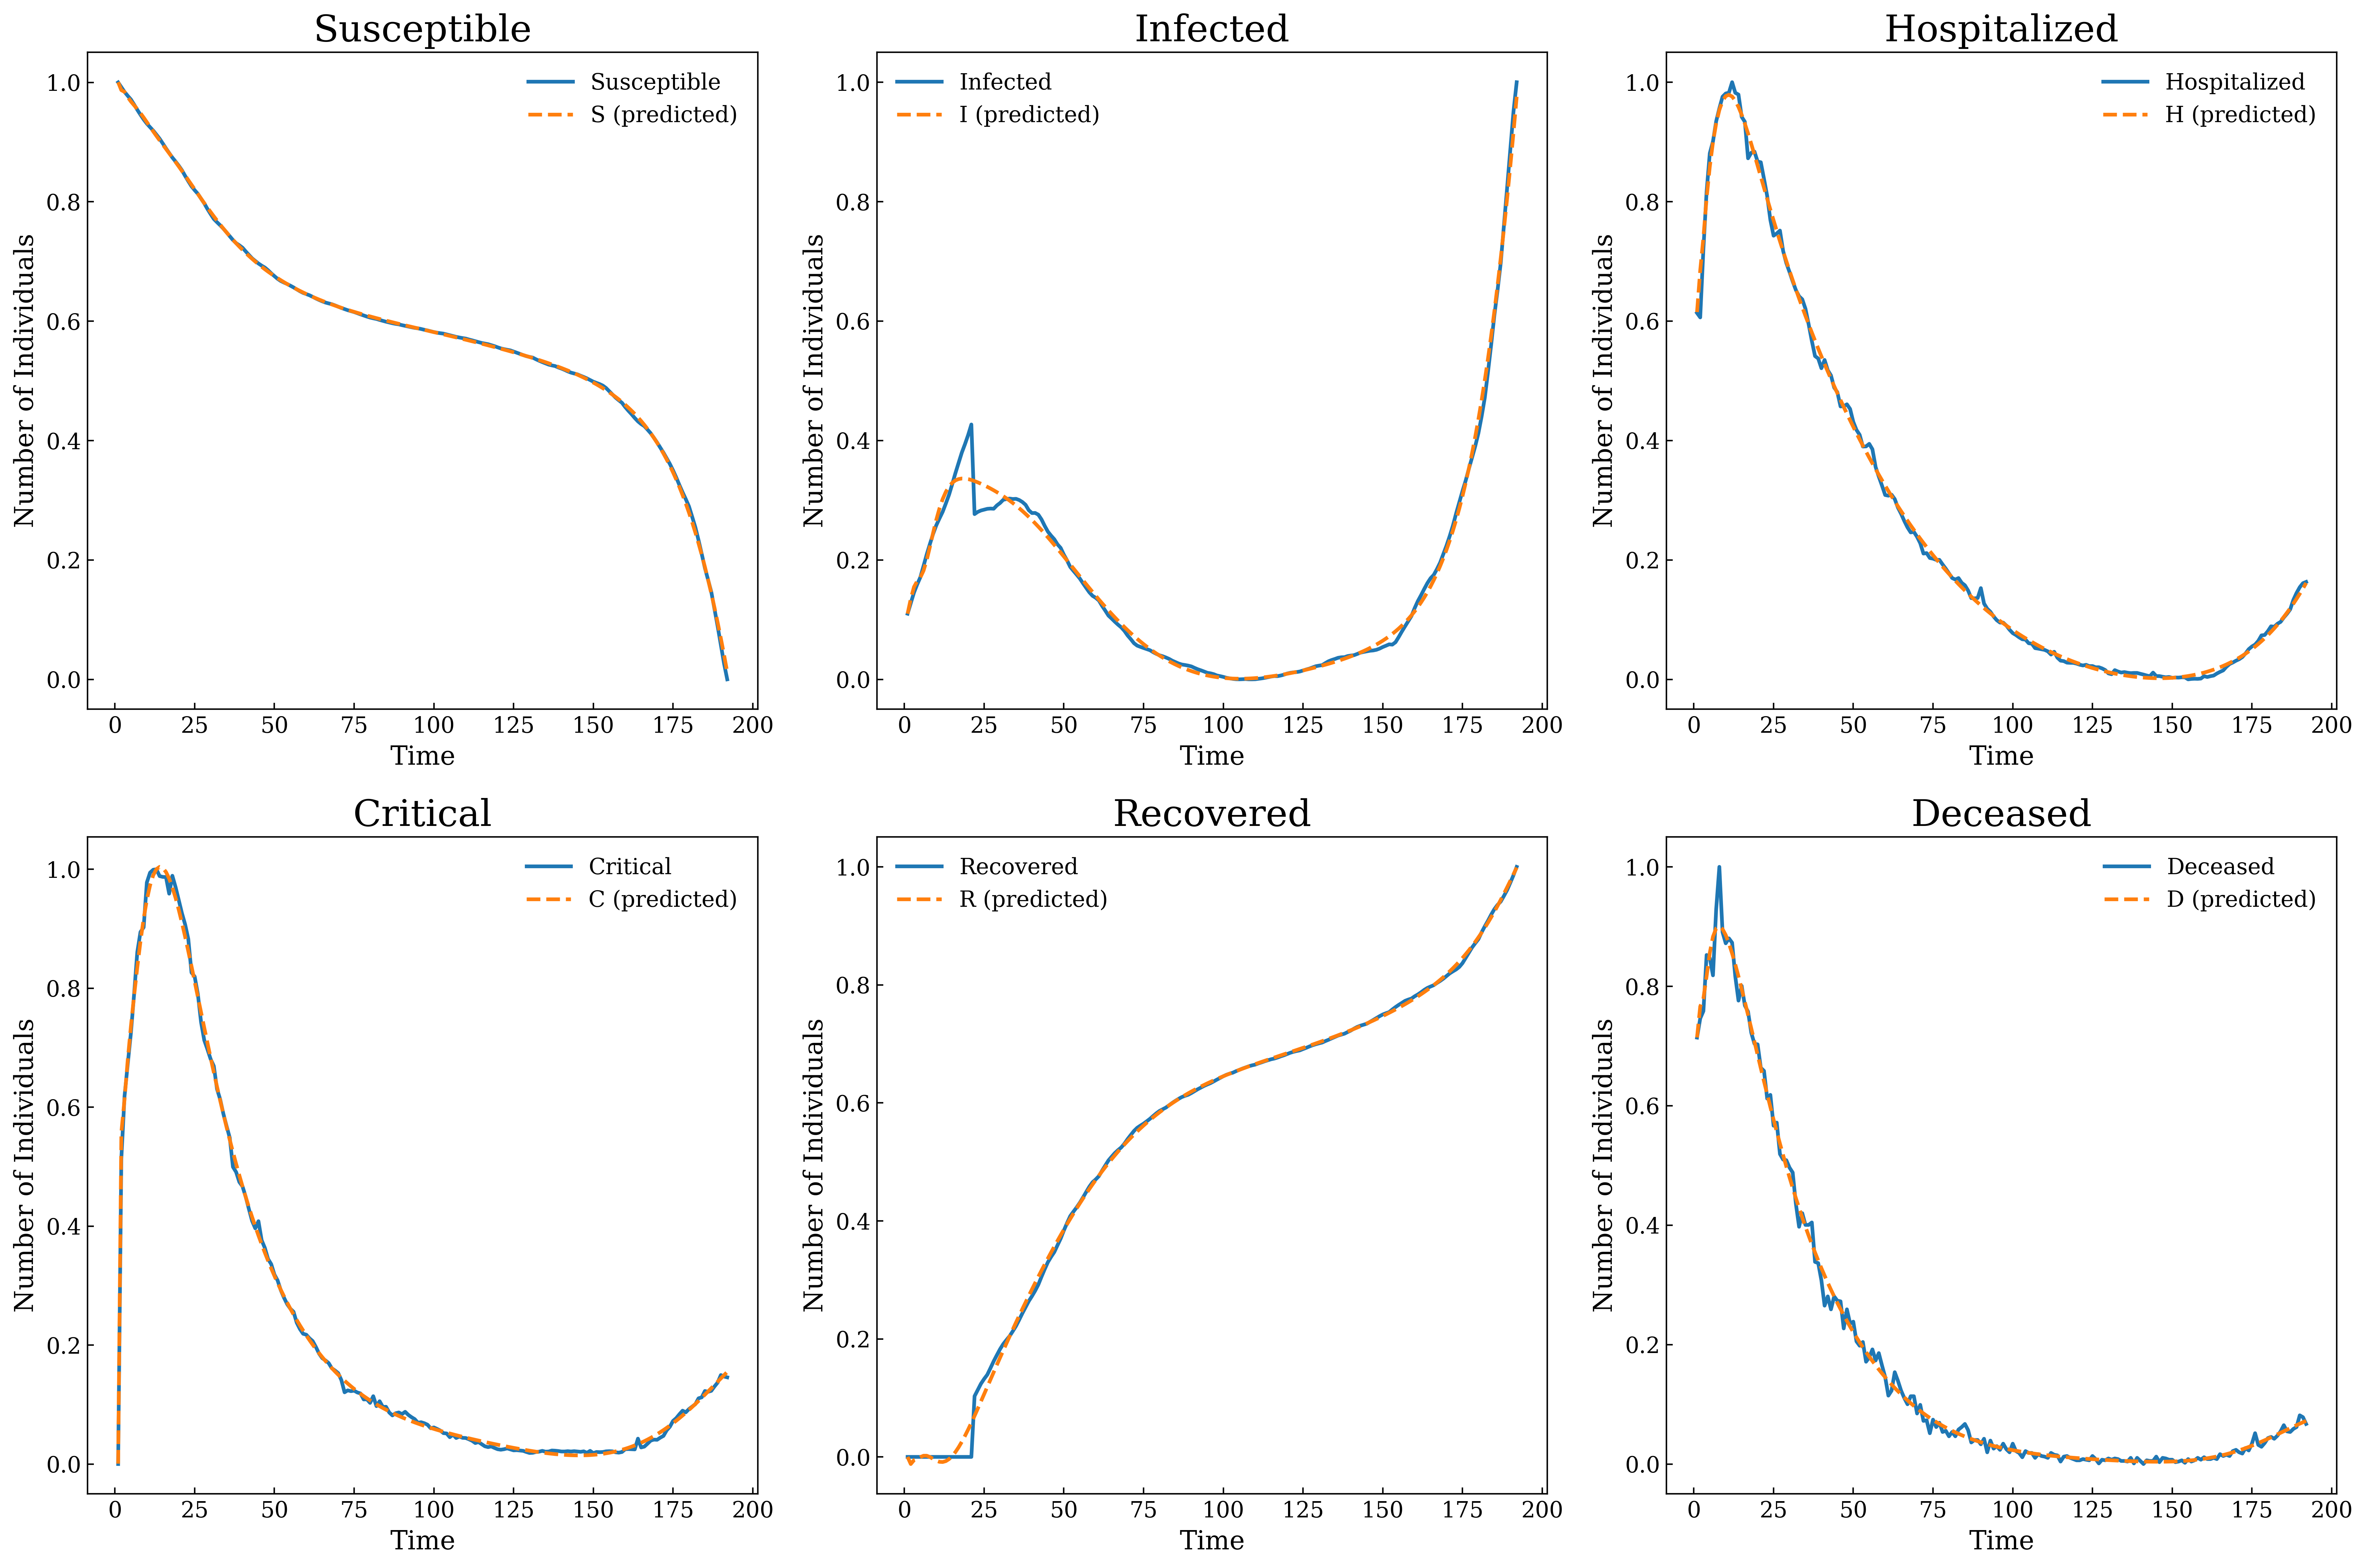

In [33]:
def plot_sihcrd_results(t, S, I, H, C, R, D, model, title):
    model.eval()
    with torch.no_grad():
        predictions = model(t).cpu().numpy()

    t_np = t.cpu().detach().numpy().flatten()
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted for SIHCRD compartments

    compartments = [
        "Susceptible",
        "Infected",
        "Hospitalized",
        "Critical",
        "Recovered",
        "Deceased",
    ]
    data = [S, I, H, C, R, D]
    pred_labels = [
        "S (predicted)",
        "I (predicted)",
        "H (predicted)",
        "C (predicted)",
        "R (predicted)",
        "D (predicted)",
    ]

    for ax, comp_data, pred, label, pred_label in zip(
        axs.flat, data, predictions.T, compartments, pred_labels
    ):
        if comp_data is not None:
            ax.plot(t_np, comp_data.cpu().detach().numpy().flatten(), label=label)
        ax.plot(t_np, pred, linestyle="dashed", label=pred_label)
        ax.set_title(label)
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Individuals")
        ax.legend()

    plt.tight_layout()
    plt.savefig(f"reports/figures/{title}.pdf")
    plt.show()

# Plot the SIHCRD model results
plot_sihcrd_results(t_train, S_train, I_train, H_train, C_train, R_train, D_train, model, "SIHCRD_Model_Predictions")

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.val_loss_min = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.val_loss_min = val_loss
            self.counter = 0


In [ ]:
def train_sihcrd(
    model,
    t_tensor,
    SIHCRD_tensor,
    epochs=1000,
    lr=0.001,
    N=None,
    beta=None,
    gamma=None,
    rho=None,
    eta=None,
    theta=None,
):
    # Setup optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=1000)
    early_stopping = EarlyStopping(patience=20, verbose=True)

    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        model_output = model(t_tensor)

        # Calculate the loss
        loss = sihcrd_loss(
            model,
            model_output,
            SIHCRD_tensor,
            t_tensor,
            N,
            beta,
            gamma,
            rho,
            eta,
            theta,
        )

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)

        # append the loss
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        early_stopping(loss)
        if early_stopping.early_stop:
            print("Early stopping")

            # save the best model
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    # "scheduler_state_dict": scheduler.state_dict(),
                    "loss": loss,
                },
                f"../../models/{model.__class__.__name__}.pt",
            )
            print("Model saved")
            break

    print("Training finished")

    return losses

In [ ]:
# parameter estimation neural network where 
class ParamNet(nn.Module):
    def __init__(self, output_size=2, num_layers=3, hidden_neurons=20):
        super(ParamNet, self).__init__()
        layers = [nn.Linear(1, hidden_neurons), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.ReLU()])
        layers.append(nn.Linear(hidden_neurons, output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

    def get_params(self, t):
        raw_params = self.forward(t)
        beta = torch.sigmoid(raw_params[:, 0]) * 0.9 + 0.1
        sigma = torch.sigmoid(raw_params[:, 1]) * 0.09 + 0.01
        gamma = torch.sigmoid(raw_params[:, 2]) * 0.09 + 0.01
        rho = torch.sigmoid(raw_params[:, 3]) * 0.09 + 0.01
        eta = torch.sigmoid(raw_params[:, 4]) * 0.09 + 0.01
        kappa = torch.sigmoid(raw_params[:, 5]) * 0.09 + 0.01
        mu = torch.sigmoid(raw_params[:, 6]) * 0.09 + 0.01
        xi = torch.sigmoid(raw_params[:, 7]) * 0.09 + 0.01
        delta = torch.sigmoid(raw_params[:, 8]) * 0.09 + 0.01
        return beta, sigma, gamma, rho, eta, kappa, mu, xi, delta
    

# class GRUParamNet(nn.Module):
#     def __init__(self, input_size=1, hidden_size=20, num_layers=1, output_size=7):
#         """
#         Initializes the GRUParamNet model.
#         input_size: int, number of input features (default is 1 for time).
#         hidden_size: int, number of features in the hidden state of the GRU.
#         num_layers: int, number of recurrent layers.
#         output_size: int, number of output parameters to estimate.
#         """
#         super(GRUParamNet, self).__init__()
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         """
#         Forward pass through the GRU model followed by a linear layer.
#         x: torch.Tensor, input tensor of shape (batch_size, sequence_length, input_size).
#         """
#         x, h_n = self.gru(x)  # x: (batch_size, seq_len, hidden_size), h_n: (num_layers, batch_size, hidden_size)
#         # We use the last hidden state
#         x = x[:, -1, :]
#         x = self.fc(x)
#         # Apply sigmoid activation function to ensure outputs are in the range (0, 1)
#         parameters = torch.sigmoid(x)
        
#         # Scale parameters according to their expected ranges
#         beta = parameters[:, 0] * 0.9 + 0.1 
#         gamma = parameters[:, 1] * 0.09 + 0.01
#         rho = parameters[:, 2] * 0.09 + 0.01
#         eta = parameters[:, 3] * 0.09 + 0.01
#         theta = parameters[:, 4] * 0.009 + 0.001
#         return beta, gamma, rho, eta, theta
    
        


class EpiNet(nn.Module):
    def __init__(self, num_layers=3, hidden_neurons=20):
        super(EpiNet, self).__init__()
        self.retrain_seed = 42  # Set the retrain_seed for reproducibility
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])
        layers.append(nn.Linear(hidden_neurons, 3))  # Output: S, I, R
        self.net = nn.Sequential(*layers)
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if isinstance(m, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_uniform_(m.weight, gain=g)
                if m.bias is not None:
                    m.bias.data.fill_(0)

        self.apply(init_weights)

In [ ]:
# Define the loss function for the SIHCRD model
def sihcrd_loss(
    model,
    model_output,
    SEIHCRD_tensor,
    t_tensor,
    N=None,
    beta_pred=None,
    sigma_pred=None,
    gamma_pred=None,
    rho_pred=None,
    eta_pred=None,
    theta_pred=None,
    kappa_pred=None,
    mu_pred=None,
    xi_pred=None,
    delta_pred=None,
):
    S_pred, E_pred, I_pred, H_pred, C_pred, R_pred, D_pred = model_output[:, 0], model_output[:, 1], model_output[:, 2], model_output[:, 3], model_output[:, 4], model_output[:, 5], model_output[:, 6] 
    
    S_actual, E_actual, I_actual, H_actual, C_actual, R_actual, D_actual = SEIHCRD_tensor[:, 0], SEIHCRD_tensor[:, 1], SEIHCRD_tensor[:, 2], SEIHCRD_tensor[:, 3], SEIHCRD_tensor[:, 4], SEIHCRD_tensor[:, 5], SEIHCRD_tensor[:, 6]

    # Derivatives of the compartments with respect to time
    S_t = torch.autograd.grad(S_pred, t_tensor, torch.ones_like(S_pred), create_graph=True)[0]  
    E_t = torch.autograd.grad(E_pred, t_tensor, torch.ones_like(E_pred), create_graph=True)[0]
    I_t = torch.autograd.grad(I_pred, t_tensor, torch.ones_like(I_pred), create_graph=True)[0]
    H_t = torch.autograd.grad(H_pred, t_tensor, torch.ones_like(H_pred), create_graph=True)[0]
    C_t = torch.autograd.grad(C_pred, t_tensor, torch.ones_like(C_pred), create_graph=True)[0]
    R_t = torch.autograd.grad(R_pred, t_tensor, torch.ones_like(R_pred), create_graph=True)[0]
    D_t = torch.autograd.grad(D_pred, t_tensor, torch.ones_like(D_pred), create_graph=True)[0]

    # Differential equations for the SIHCRD model
    dSdt = -(beta_pred * S_pred * I_pred) / N
    dEdt = (beta_pred * S_pred * I_pred) / N - sigma_pred * E_pred
    dIdt = sigma_pred * E_pred - gamma_pred * I_pred - rho_pred * I_pred
    dHdt = rho_pred * I_pred - eta_pred * H_pred - gamma_pred * H_pred
    dCdt = eta_pred * H_pred - theta_pred * C_pred - gamma_pred * C_pred
    dRdt = gamma_pred * (I_pred + H_pred + C_pred)
    dDdt = theta_pred * C_pred

    # Physics-informed loss: the difference between the predicted derivatives and the actual rate of change
    physics_loss = torch.mean((S_t - dSdt) ** 2) + torch.mean((E_t - dEdt) ** 2) + \
                   torch.mean((I_t - dIdt) ** 2) + torch.mean((H_t - dHdt) ** 2) + \                   
                   torch.mean((C_t - dCdt) ** 2) + torch.mean((R_t - dRdt) ** 2) + \
                   torch.mean((D_t - dDdt) ** 2)     

    # data loss
    data_loss = torch.mean((S_actual - S_pred) ** 2) + torch.mean((E_actual - E_pred) ** 2) + \
                torch.mean((I_actual - I_pred) ** 2) + torch.mean((H_actual - H_pred) ** 2) + \
                torch.mean((C_actual - C_pred) ** 2) + torch.mean((R_actual - R_pred) ** 2) + \
                torch.mean((D_actual - D_pred) ** 2)

    total_loss = data_loss + physics_loss
    return total_loss

In [ ]:
# Early stopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
# Initialize the models
param_model = GRUParamNet(input_size=1, hidden_size=32, num_layers=5).to(device)
epi_model = EpiNet(num_layers=5, hidden_neurons=32).to(device)

In [ ]:
# Training function
def time_varying_PINN_training(param_model, epi_model, train_loader, optimizer, epochs):
    """
    Function to train the time-varying PINN model.
    param_model: nn.Module, the parameter estimation model.
    epi_model: nn.Module, the epidemiological model.
    train_loader: DataLoader, the training data loader.
    optimizer: torch.optim.Optimizer, the optimizer for training.
    epochs: int, the number of training epochs.
    """
    # Initialize the early stopping callback
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    losses = []     # List to store the losses  

    # Training loop
    for epoch in tqdm(range(epochs), desc="Training", unit="epoch", position=0, leave=True):
        
        # Set the model to training mode
        param_model.train()
        epi_model.train()
        
        # forward pass: compute predicted outputs by passing inputs to the model, and parameter estimation model
        beta_pred, gamma_pred, rho_pred, eta_pred, theta_pred = param_model(train_loader)
        S_pred, I_pred, H_pred, C_pred, R_pred, D_pred = epi_model(train_loader)    

In [ ]:
losses = 

SyntaxError: invalid syntax (1284818843.py, line 1)